In [89]:
import numpy as np
import cmath
from scipy import fftpack as fftp
from scipy import stats
import os
import random as rm
from scipy import ndimage

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
output_dir = output_dir = os.path.join('.','output')

# Ejemplo 1 - Diferenciación


In [157]:
# Setup the problem

L1=20 # define the computational domain [-L/2,L/2]
n1=128 # define the number of Fourier modes 2^n

x2=linspace(-L1/2,L1/2,n1+1); # define the domain discretization
x=x2[0:n] # consider only the first n points: periodicity

dx=x[1]-x[0] # dx value needed for finite difference
u1 = 1/np.cosh(x) # function to take a derivative of
k_vect = np.concatenate([np.arange(0,(n1/2-1)+1),np.arange((-n1/2),-1+1)]) # Create a vector to apply to k
k1=(2*np.pi/L1)*k_vect # k rescaled to 2pi domain

ut_1=fftp.fft(u) # FFT the function

In [158]:
#  FFT calculation of derivatives

ut1=1j*k*ut_1 # first derivative
ut2=-k*k*ut_1 # second derivative
u1=fftp.ifft(ut1).real # inverse transform
u2=fftp.ifft(ut2).real # inverse transform

u1exact=(-1/np.cosh(x))*tanh(x) # analytic first derivative
u2exact=(1/np.cosh(x))-2*(1/np.cosh(x))**3 # analytic second derivative

In [159]:
# Calcular la derivada usando np.gradient - usa diferencias finitas con precisión de orden 2

ux1=np.gradient(u,dx)
ux2=np.gradient(ux1,dx)

In [148]:
# Función para calcular el error RMSEN entre las series

def rmsen(old,new):   
    
    n = len(new)
    resta = [] 

    for i in range(n):
        x_old = old[i]
        x_new = new[i]

        x = (x_old - x_new)**2

        resta.append(x)

    error = np.sqrt((1/n)*sum(resta))/(np.max(old) - np.min(old))
        
    print("El error RMSEn es: {0:.5f}%".format(error*100))

    return error  

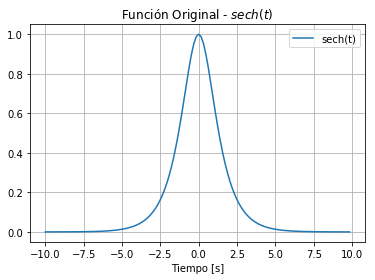

In [149]:
pylab.plot(x,u,label='sech(t)')
pylab.title('Función Original - $sech(t)$')
pylab.xlabel('Tiempo [s]')
pylab.grid()
pylab.legend(loc='best')

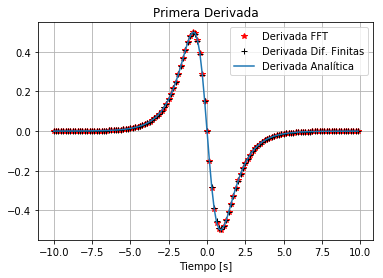

In [150]:
pylab.plot(x,u1,'r*',label='Derivada FFT')
pylab.plot(x,ux1,'k+',label='Derivada Dif. Finitas')
pylab.plot(x,u1exact,label='Derivada Analítica')
pylab.title('Primera Derivada')
pylab.xlabel('Tiempo [s]')
pylab.grid()
pylab.legend(loc='best')

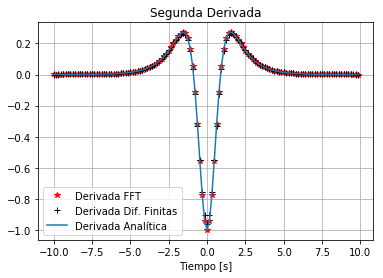

In [151]:
pylab.plot(x,u2,'r*',label='Derivada FFT')
pylab.plot(x,ux2,'k+',label='Derivada Dif. Finitas')
pylab.plot(x,u2exact,label='Derivada Analítica')
pylab.title('Segunda Derivada')
pylab.xlabel('Tiempo [s]')
pylab.grid()
pylab.legend(loc='best')

In [152]:
# Calcular Errores
print('Primera Derivada')
rmsen_exact1 = rmsen(u1exact,u1exact)
rmsen_fft1 = rmsen(u1exact,u1)
rmesn_dif1 = rmsen(u1exact,ux1)
print('\n')

print('Segunda Derivada')
rmsen_exact2 = rmsen(u2exact,u2exact)
rmsen_fft2 = rmsen(u2exact,u2)
rmesn_dif2 = rmsen(u2exact,ux2)

Primera Derivada
El error RMSEn es: 0.00000%
El error RMSEn es: 0.00101%
El error RMSEn es: 0.15572%


Segunda Derivada
El error RMSEn es: 0.00000%
El error RMSEn es: 0.01167%
El error RMSEn es: 0.57166%


# Constantes - Ejemplos Filtros

In [233]:
L=30 # time slot to transform
n=512 # number of Fourier modes 2^9
t2=linspace(-L,L,n+1) 
t=t2[0:n] # time discretization

k_vect2 = np.concatenate([np.arange(0,(n/2-1)+1),np.arange((-n/2),-1+1)]) # Create a vector to apply to k
k=(2*np.pi/(2*L))*k_vect2 # frequency components of FFT
ks = fftp.fftshift(k) #Apply shift to k

u=1/np.cosh(t) # ideal signal in the time domain
ut = fftp.fft(u) # FFT the function

noise = 10 # noise level

# Ejemplo 2 - Filtrado Simple

In [271]:
wn_2 = np.random.normal(0,1,n) # white noise
unt_2 = ut + noise*(wn_2+1j*wn_2) # add noise
un_2 = fftp.ifft(unt_2) # return to time domain

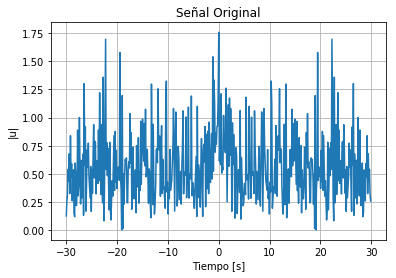

In [249]:
pylab.plot(t,np.abs(un_2))
pylab.title('Señal Original')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

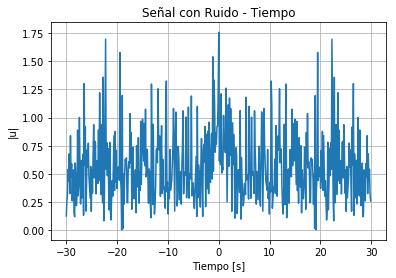

In [250]:
pylab.plot(t,np.abs(un_2))
pylab.title('Señal con Ruido - Tiempo')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

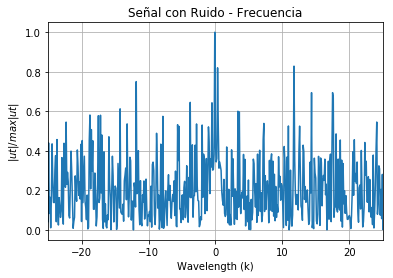

In [251]:
pylab.plot(ks,(np.abs(fftp.fftshift(unt_2))/np.max(np.abs(fftp.fftshift(unt_2)))))
pylab.title('Señal con Ruido - Frecuencia')
pylab.xlabel('Wavelength (k)')
pylab.ylabel('$|ut|/max|ut|$')
pylab.xlim([-25,25])
pylab.grid()
pylab.legend(loc='best')

In [252]:
# unft = ndimage.gaussian_filter(unt.real,1)
unfk = exp(-0.2*((k_2)**2))*unt_2 # Aplicar filtro en dominio freq
unft = fftp.ifft(unfk) # Devolverse a dominio tiempo

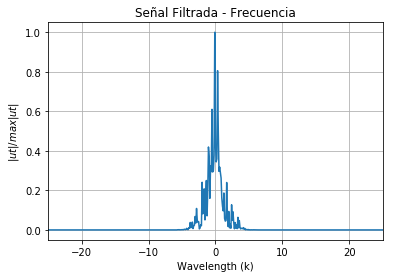

In [253]:
pylab.plot(ks,(np.abs(fftp.fftshift(unfk))/np.max(np.abs(fftp.fftshift(unfk)))))
pylab.title('Señal Filtrada - Frecuencia')
pylab.xlabel('Wavelength (k)')
pylab.ylabel('$|ut|/max|ut|$')
pylab.xlim([-25,25])
pylab.grid()
pylab.legend(loc='best')

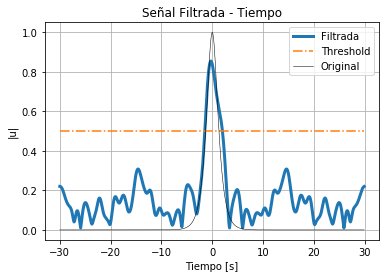

In [254]:
pylab.plot(t,np.abs(unft),linewidth=3.0, label='Filtrada')
pylab.plot(t,linspace(0.5,0.5,len(t)), '-.', label='Threshold')
pylab.plot(t,np.abs(u_2),'k',linewidth=0.5, label='Original')
pylab.title('Señal Filtrada - Tiempo')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

# Ejemplo 3 - Promediar Señales

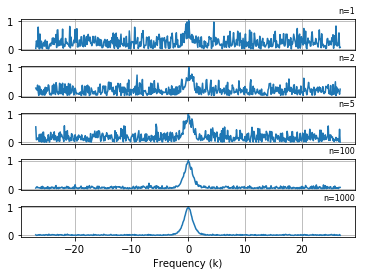

In [335]:
realize = [1,2,5,100,1000]

signals = []

f, axarr = plt.subplots(len(realize), sharex=True)
f.subplots_adjust(hspace=0.5)

for ii in range(len(realize)):
    
    ave = np.zeros(n)
    
    for i in range(realize[ii]):
    
        wn = np.random.normal(0,1,n) # white noise
        utn = ut + noise*(wn+1j*wn) # add noise
        
        ave = ave + utn
        
    ave = ave/realize[ii]
    
    data = (np.abs(fftp.fftshift(ave))/np.max(np.abs(fftp.fftshift(ave))))
    
    signals.append(data)
    
    axarr[ii].plot(ks, data)
    axarr[ii].set_title('n={}'.format(realize[ii]), 
                        loc='right',
                        fontsize = 8)
    axarr[ii].grid()
    axarr[len(realize)-1].set_xlabel('Frequency (k)')
    

#pylab.savefig(os.path.join(output_dir,'Averaging.png'), dpi=600)